In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Setup models to use and needed parameters for model selection
testSize = 0.25 #percentage of total set
k = 5 # for K-fold cross-validation
GBC = GradientBoostingClassifier()
RFC = RandomForestClassifier()
DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier()
models = [('Linear',linear,RFE(linear)),
          ('Gradient Boosting', GBC, SelectFromModel(GBC)),
          ('Random Forests',RFC,SelectFromModel(RFC)),
          ('Decision tree',DTC,SelectFromModel(DTC)),
          ('Adaboost',ABC,SelectFromModel(ABC))]

In [3]:
# load the data
X = pd.read_csv("../multiclass/X.csv",header=None).values
y = pd.read_csv("../multiclass/y.csv",header=None,squeeze=True).values
waveLengths = pd.read_csv("../multiclass/Wavelength.csv",header=None)
X_toClassify = pd.read_csv("../multiclass/XtoClassify.csv",header=None).values
# Put aside data for testing at the end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)


# Do some standard normalisation
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_toClassify = scaler.transform(X_toClassify)

In [4]:
# Get a baseline accruaccy
linear = LogisticRegression()
linear_selector = RFE(linear)
linear.fit(X_train,y_train)
f1_score(linear.predict(X_train),y_train,average='micro')

1.0

In [8]:
# Setup a dataframe to contain the results
results = pd.DataFrame(columns=['Algorithm',
                                'Mean score',
                                'Total operation time on full feature set',
                                'Number of important features',
                                "Mean score on reduced feature set",
                                "Total operation time on reduced feature set"])

# Loop over the models and test their performance using cross validation and the f1 score
for name, model, selector in models:
    scores = cross_validate(model,X_train,y_train,cv=k,scoring='f1_micro')
    
    # Can we do just as well with fewer features?
    selector.fit(X_train,y_train)
    X_reduced = selector.transform(X_train)
    scores_reduced = cross_validate(model,X_reduced,y_train,cv=k,scoring='f1_micro')

    # Record the results
    results.loc[len(results)] = pd.Series({
        'Algorithm' : name,
        "Mean score":scores['test_score'].mean(),
        "Total operation time on full feature set" : sum(scores['fit_time'])+sum(scores['score_time']),
        "Number of important features":sum(selector.get_support()),
        "Mean score on reduced feature set":scores_reduced['test_score'].mean(),
        "Total operation time on reduced feature set" : sum(scores_reduced['fit_time'])+sum(scores_reduced['score_time'])                                                                                                                                                    
    })

# calculate the 'rating' to determine the best model. Based on accuracy and operation time. Higher is better
results['Rating'] = results['Mean score on reduced feature set'] /results['Total operation time on reduced feature set']
results.sort_values('Rating',ascending=False,inplace=True)
bestModelRecord = results.iloc[0]
results

,Algorithm,Mean score,Total operation time on full feature set,Number of important features,Mean score on reduced feature set,Total operation time on reduced feature set,Rating
3,Decision tree,0.994066,0.301784,4,1.000000,0.005924,168.798455
2,Random Forests,1.000000,0.145891,40,1.000000,0.089507,11.172357
0,Linear,1.000000,0.808015,460,1.000000,0.360930,2.770617
4,Adaboost,0.834122,6.024803,29,0.813190,0.580950,1.399759
1,Gradient Boosting,0.988188,13.675776,94,0.997143,2.365873,0.421469


In [7]:
# Find the best model
for name,model,selector in models:
    if name == bestModelRecord['Algorithm']:
        bestModel = model
        bestSelector = selector
        
# Train the best model on the reduced feature set and report the accuracy
bestModel.fit(bestSelector.fit_transform(X_train,y_train),y_train)
f1_score(bestModel.predict(bestSelector.transform(X_test)),y_test,average='micro')

1.0

In [7]:
# Use trained model to predict and store the results of the samples to classify
# Note that X_toClassify was already normalised
pd.DataFrame(bestModel.predict(bestSelector.transform(X_toClassify))).to_csv("../multiclass/PredictedClasses.csv",index=False)

In [24]:
bestFeatures = bestSelector.get_support()
df = pd.concat([
        pd.DataFrame(X[:,bestFeatures],columns=[numb for wl in waveLengths[bestFeatures].values.tolist() for numb in wl ]),
        pd.DataFrame(y,columns=["label"])]
    ,axis=1)
df.head()

,513.929,560.679,602.4780000000001,712.0310000000001,label
0,28.82,21.93,12.61,2.43,1
1,10.82,7.82,26.48,69.33,2
2,30.62,59.18,63.35,55.49,4
3,-0.18,3.70,17.04,55.44,3
4,3.19,1.05,2.61,-12.08,0


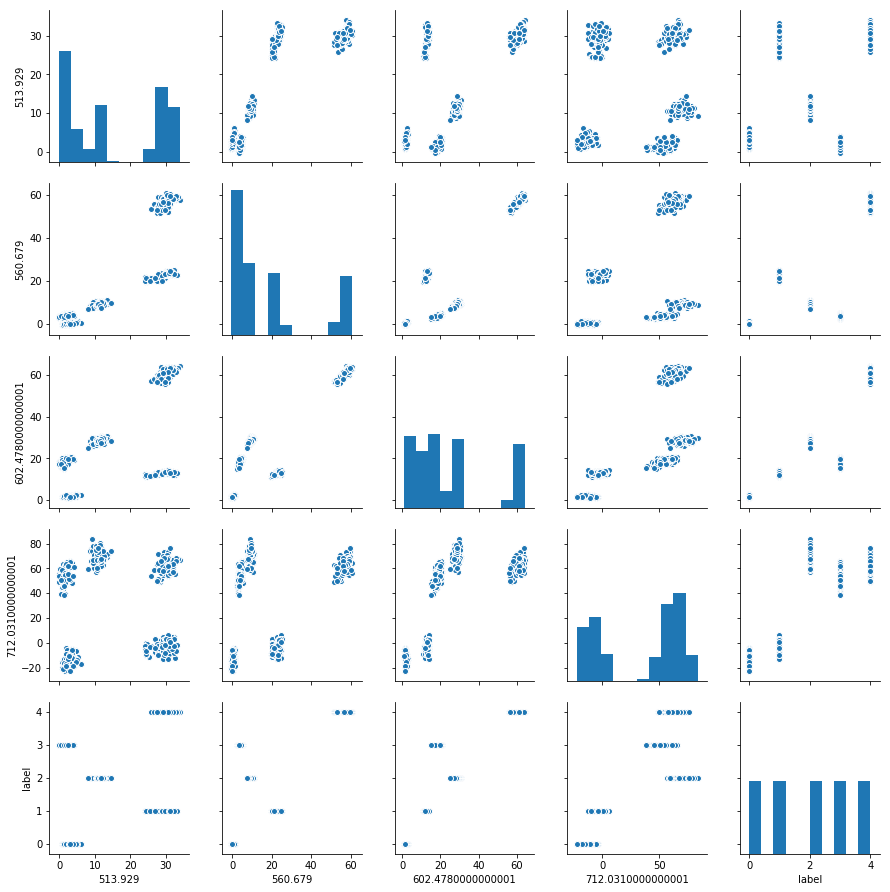

In [29]:
sns.pairplot(df)